# Problem Statement

To build a multiple linear regression model for the prediction of demand for shared bikes.

## Steps involved in the process

1. Reading, understanding and visualising the data
2. Preaparing the data for modelling (tain-test split, rescaling etc.)
3. Training the model
4. Residual Analysis
5. Predictions and evaluation on the test set

## Step 1 : Reading , understanding and Visualising the data

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading data

bikeSharing = pd.read_csv('day.csv')
bikeSharing.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
bikeSharing.shape

(730, 16)

In [4]:
bikeSharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
bikeSharing.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


<Figure size 2500x2000 with 0 Axes>

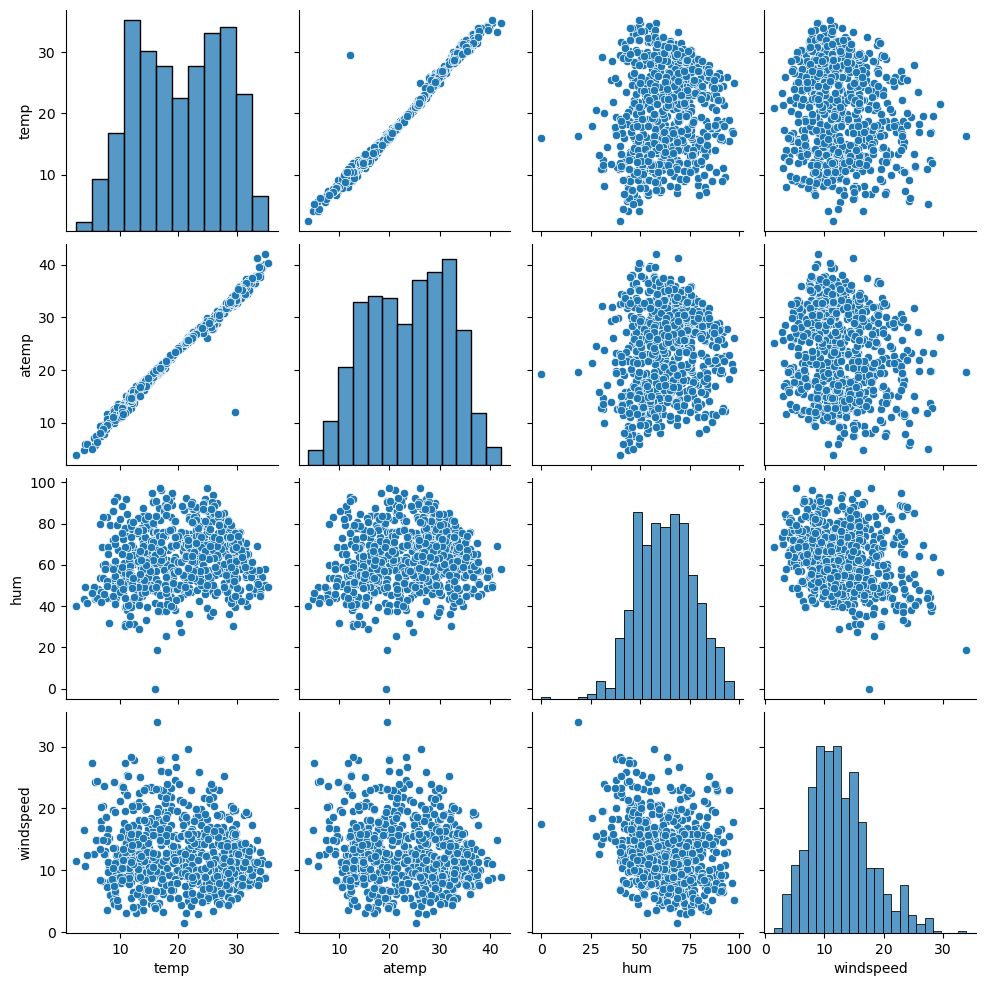

In [6]:
#visualising the numerical variables

plt.figure(figsize=(25,20))
sns.pairplot(bikeSharing, vars=['temp','atemp','hum','windspeed'])
plt.show()

In [7]:
# some categorical variables appear to be numberical lets fix that

bikeSharing[['season']] = bikeSharing[['season']].apply(lambda x: x.map({1: 'spring',2:'summer',3:'fall',4:'winter'}))
bikeSharing[['weathersit']] = bikeSharing[['weathersit']].apply(lambda x: x.map({1: 'clear/part cloudy',2:'mist_cloudy',3:'light_snow/light_rain',4:'heavy_rain/thunderstorm/snow_fog'}))
bikeSharing[['mnth']] = bikeSharing[['mnth']].apply(lambda x: x.map({1: 'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}))
bikeSharing[['weekday']] = bikeSharing[['weekday']].apply(lambda x: x.map({0: 'Tue',1:'Wed',2:'Thu',3:'Fri',4:'Sat',5:'Sun',6:'Mon'}))



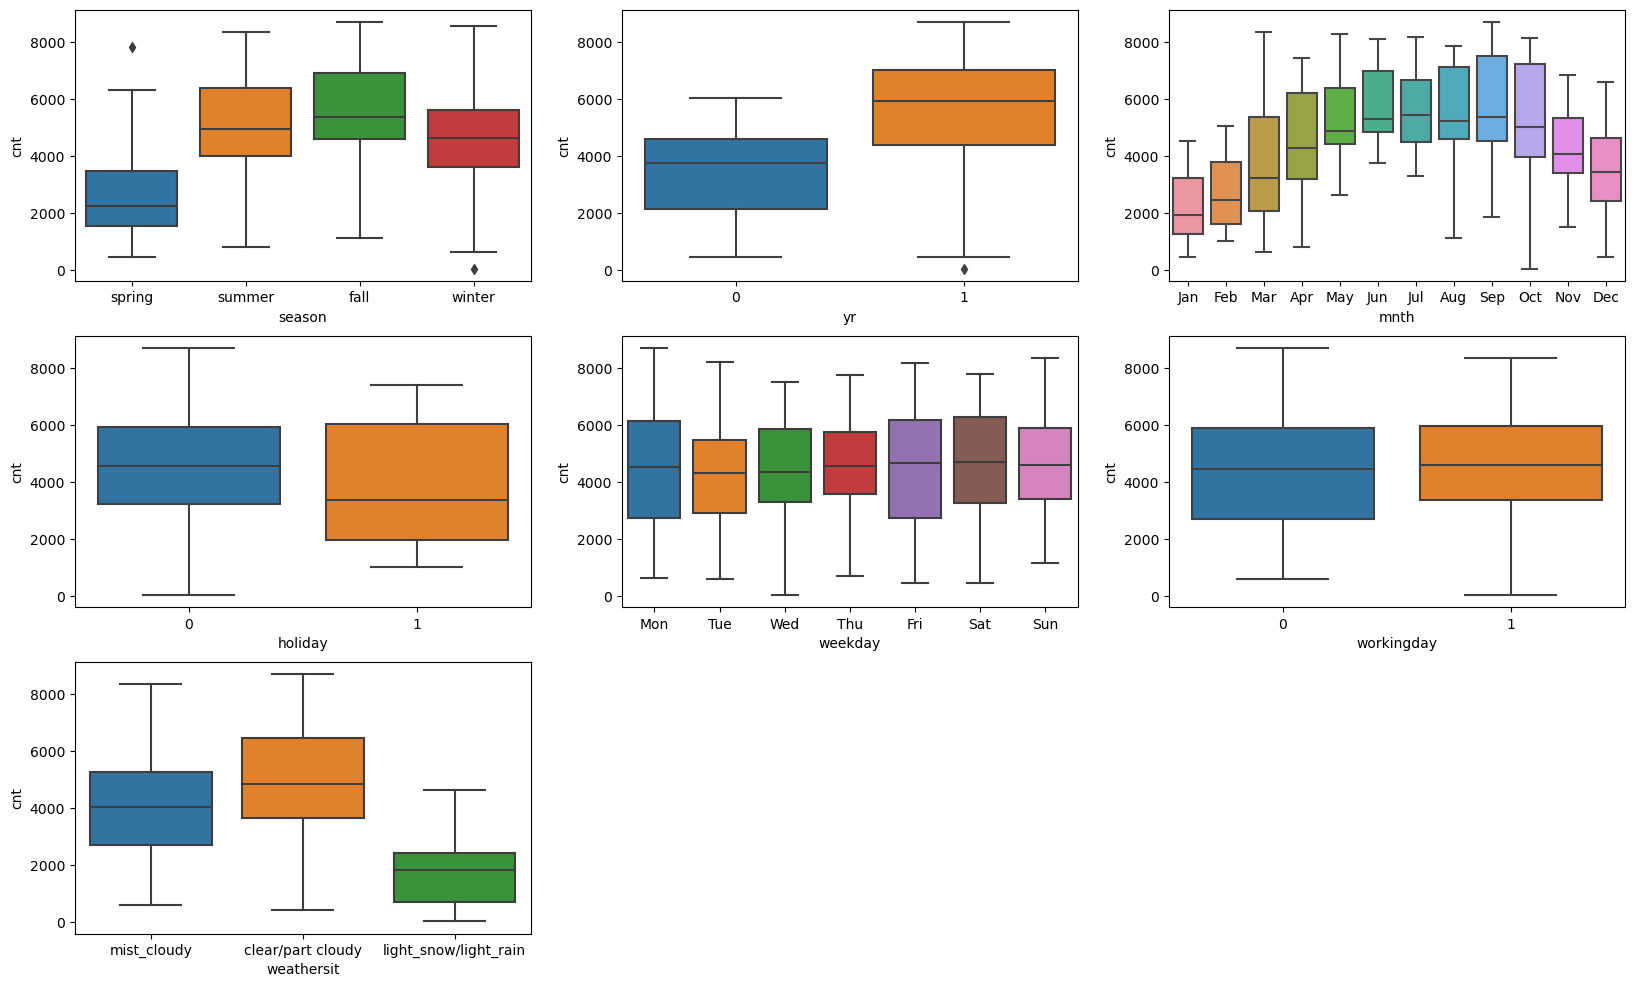

In [8]:
# visualising the categorical variable

plt.figure(figsize=(20,12))
plt.subplot(3,3,1)
sns.boxplot(x="season",y="cnt",data=bikeSharing)
plt.subplot(3,3,2)
sns.boxplot(x="yr",y="cnt",data=bikeSharing)
plt.subplot(3,3,3)
sns.boxplot(x="mnth",y="cnt",data=bikeSharing)
plt.subplot(3,3,4)
sns.boxplot(x="holiday",y="cnt",data=bikeSharing)
plt.subplot(3,3,5)
sns.boxplot(x="weekday",y="cnt",data=bikeSharing)
plt.subplot(3,3,6)
sns.boxplot(x="workingday",y="cnt",data=bikeSharing)
plt.subplot(3,3,7)
sns.boxplot(x="weathersit",y="cnt",data=bikeSharing)
plt.show()

## Step 2: Preparing the data for modelling

- Encoding:
    - Converting categorical vars to dummy vars
- Splitting into train and test
- Rescaling of variables

### Dummy variables

In [9]:
# creating dummy variables for season

season_dummy = pd.get_dummies(bikeSharing['season'])
season_dummy.head()

,fall,spring,summer,winter
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


Now we dont need four columns. We can drop the `fall` column, as the type of season can be identified with just the last three columns as -

- `000` will corresponds to `fall`
- `100` will corresponds to `spring`
- `010` will corresponds to `summer`
- `001` will corresponds to `winter`

In [10]:
# dropping the reduant dummy var for season

season_dummy = pd.get_dummies(bikeSharing['season'], drop_first=True)
season_dummy.head()

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [11]:
# concat the dummy df with the original one

bikeSharing = pd.concat([bikeSharing, season_dummy], axis=1)
bikeSharing.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter
0,1,01-01-2018,spring,0,Jan,0,Mon,0,mist_cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0
1,2,02-01-2018,spring,0,Jan,0,Tue,0,mist_cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0
2,3,03-01-2018,spring,0,Jan,0,Wed,1,clear/part cloudy,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0
3,4,04-01-2018,spring,0,Jan,0,Thu,1,clear/part cloudy,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0
4,5,05-01-2018,spring,0,Jan,0,Fri,1,clear/part cloudy,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0


In [12]:
bikeSharing = bikeSharing.drop('season', axis=1)
bikeSharing.head()

,instant,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter
0,1,01-01-2018,0,Jan,0,Mon,0,mist_cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0
1,2,02-01-2018,0,Jan,0,Tue,0,mist_cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0
2,3,03-01-2018,0,Jan,0,Wed,1,clear/part cloudy,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0
3,4,04-01-2018,0,Jan,0,Thu,1,clear/part cloudy,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0
4,5,05-01-2018,0,Jan,0,Fri,1,clear/part cloudy,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0


In [13]:
# creating dummy variables for weathersit

weathersit_dummy = pd.get_dummies(bikeSharing['weathersit'])
weathersit_dummy.head()

,clear/part cloudy,light_snow/light_rain,mist_cloudy
0,0,0,1
1,0,0,1
2,1,0,0
3,1,0,0
4,1,0,0


We can drop the `heavy_rain/thunderstorm/snow_fog` column as it has no data as well, as the type of season can be identified with just the last three columns as -

- `000` will corresponds to `heavy_rain/thunderstorm/snow_fog`
- `100` will corresponds to `clear/part cloudy`
- `010` will corresponds to `light_snow/light_rain`
- `001` will corresponds to `mist_cloudy`

In [14]:
# concat the dummy df with the original one

bikeSharing = pd.concat([bikeSharing, weathersit_dummy], axis=1)
bikeSharing.head()

,instant,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,...,windspeed,casual,registered,cnt,spring,summer,winter,clear/part cloudy,light_snow/light_rain,mist_cloudy
0,1,01-01-2018,0,Jan,0,Mon,0,mist_cloudy,14.110847,18.18125,...,10.749882,331,654,985,1,0,0,0,0,1
1,2,02-01-2018,0,Jan,0,Tue,0,mist_cloudy,14.902598,17.68695,...,16.652113,131,670,801,1,0,0,0,0,1
2,3,03-01-2018,0,Jan,0,Wed,1,clear/part cloudy,8.050924,9.47025,...,16.636703,120,1229,1349,1,0,0,1,0,0
3,4,04-01-2018,0,Jan,0,Thu,1,clear/part cloudy,8.200000,10.60610,...,10.739832,108,1454,1562,1,0,0,1,0,0
4,5,05-01-2018,0,Jan,0,Fri,1,clear/part cloudy,9.305237,11.46350,...,12.522300,82,1518,1600,1,0,0,1,0,0


In [15]:
bikeSharing = bikeSharing.drop('weathersit', axis=1)
bikeSharing.head()

,instant,dteday,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter,clear/part cloudy,light_snow/light_rain,mist_cloudy
0,1,01-01-2018,0,Jan,0,Mon,0,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0,0,0,1
1,2,02-01-2018,0,Jan,0,Tue,0,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0,0,0,1
2,3,03-01-2018,0,Jan,0,Wed,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0,1,0,0
3,4,04-01-2018,0,Jan,0,Thu,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0,1,0,0
4,5,05-01-2018,0,Jan,0,Fri,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0,1,0,0


In [16]:
# creating dummy variables for mnth

weathersit_dummy = pd.get_dummies(bikeSharing['mnth'])
weathersit_dummy.head()


,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0


In [17]:
# dropping the reduant dummy var for mnth

month_dummy = pd.get_dummies(bikeSharing['mnth'], drop_first=True)
month_dummy.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [18]:
# concat the dummy df with the original one

bikeSharing = pd.concat([bikeSharing, month_dummy], axis=1)
bikeSharing.head()

,instant,dteday,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1,01-01-2018,0,Jan,0,Mon,0,14.110847,18.18125,80.5833,...,0,0,1,0,0,0,0,0,0,0
1,2,02-01-2018,0,Jan,0,Tue,0,14.902598,17.68695,69.6087,...,0,0,1,0,0,0,0,0,0,0
2,3,03-01-2018,0,Jan,0,Wed,1,8.050924,9.47025,43.7273,...,0,0,1,0,0,0,0,0,0,0
3,4,04-01-2018,0,Jan,0,Thu,1,8.200000,10.60610,59.0435,...,0,0,1,0,0,0,0,0,0,0
4,5,05-01-2018,0,Jan,0,Fri,1,9.305237,11.46350,43.6957,...,0,0,1,0,0,0,0,0,0,0


In [19]:
bikeSharing = bikeSharing.drop('mnth', axis=1)
bikeSharing.head()

,instant,dteday,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1,01-01-2018,0,0,Mon,0,14.110847,18.18125,80.5833,10.749882,...,0,0,1,0,0,0,0,0,0,0
1,2,02-01-2018,0,0,Tue,0,14.902598,17.68695,69.6087,16.652113,...,0,0,1,0,0,0,0,0,0,0
2,3,03-01-2018,0,0,Wed,1,8.050924,9.47025,43.7273,16.636703,...,0,0,1,0,0,0,0,0,0,0
3,4,04-01-2018,0,0,Thu,1,8.200000,10.60610,59.0435,10.739832,...,0,0,1,0,0,0,0,0,0,0
4,5,05-01-2018,0,0,Fri,1,9.305237,11.46350,43.6957,12.522300,...,0,0,1,0,0,0,0,0,0,0


In [20]:
# creating dummy variables for weekday

weekday_dummy = pd.get_dummies(bikeSharing['weekday'])
weekday_dummy.head()

,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0


In [21]:
# dropping the reduant dummy var for weekday

weekday_dummy = pd.get_dummies(bikeSharing['weekday'], drop_first=True)
weekday_dummy.head()

,Mon,Sat,Sun,Thu,Tue,Wed
0,1,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,0,0,0,0


In [22]:
# concat the dummy df with the original one

bikeSharing = pd.concat([bikeSharing, weekday_dummy], axis=1)
bikeSharing.head()

,instant,dteday,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
0,1,01-01-2018,0,0,Mon,0,14.110847,18.18125,80.5833,10.749882,...,0,0,0,0,1,0,0,0,0,0
1,2,02-01-2018,0,0,Tue,0,14.902598,17.68695,69.6087,16.652113,...,0,0,0,0,0,0,0,0,1,0
2,3,03-01-2018,0,0,Wed,1,8.050924,9.47025,43.7273,16.636703,...,0,0,0,0,0,0,0,0,0,1
3,4,04-01-2018,0,0,Thu,1,8.200000,10.60610,59.0435,10.739832,...,0,0,0,0,0,0,0,1,0,0
4,5,05-01-2018,0,0,Fri,1,9.305237,11.46350,43.6957,12.522300,...,0,0,0,0,0,0,0,0,0,0


In [23]:
bikeSharing = bikeSharing.drop('weekday', axis=1)
bikeSharing.head()

,instant,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
0,1,01-01-2018,0,0,0,14.110847,18.18125,80.5833,10.749882,331,...,0,0,0,0,1,0,0,0,0,0
1,2,02-01-2018,0,0,0,14.902598,17.68695,69.6087,16.652113,131,...,0,0,0,0,0,0,0,0,1,0
2,3,03-01-2018,0,0,1,8.050924,9.47025,43.7273,16.636703,120,...,0,0,0,0,0,0,0,0,0,1
3,4,04-01-2018,0,0,1,8.200000,10.60610,59.0435,10.739832,108,...,0,0,0,0,0,0,0,1,0,0
4,5,05-01-2018,0,0,1,9.305237,11.46350,43.6957,12.522300,82,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# dropping columns which will not be part of model training
bikeSharing = bikeSharing.drop('dteday', axis=1)
bikeSharing = bikeSharing.drop('instant', axis=1)
bikeSharing = bikeSharing.drop('casual', axis=1)
bikeSharing = bikeSharing.drop('registered', axis=1)

### Splitting into train and test

In [25]:
df_train,df_test = train_test_split(bikeSharing, train_size=0.7,random_state = 100)
print(df_train.shape)
print(df_test.shape)

(510, 31)
(220, 31)


### Rescaling the features

In [26]:
# Using MinMax Scaling

scaler = MinMaxScaler()

num_vars = ['temp','atemp','hum','windspeed']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train[num_vars].describe()

,temp,atemp,hum,windspeed
count,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.513156,0.650480,0.320883
std,0.225858,0.212410,0.145846,0.169803
min,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.332086,0.538643,0.199179
50%,0.542596,0.529718,0.653714,0.296763
75%,0.735215,0.688457,0.754830,0.414447
max,1.000000,1.000000,1.000000,1.000000


## Step 3: Training the model

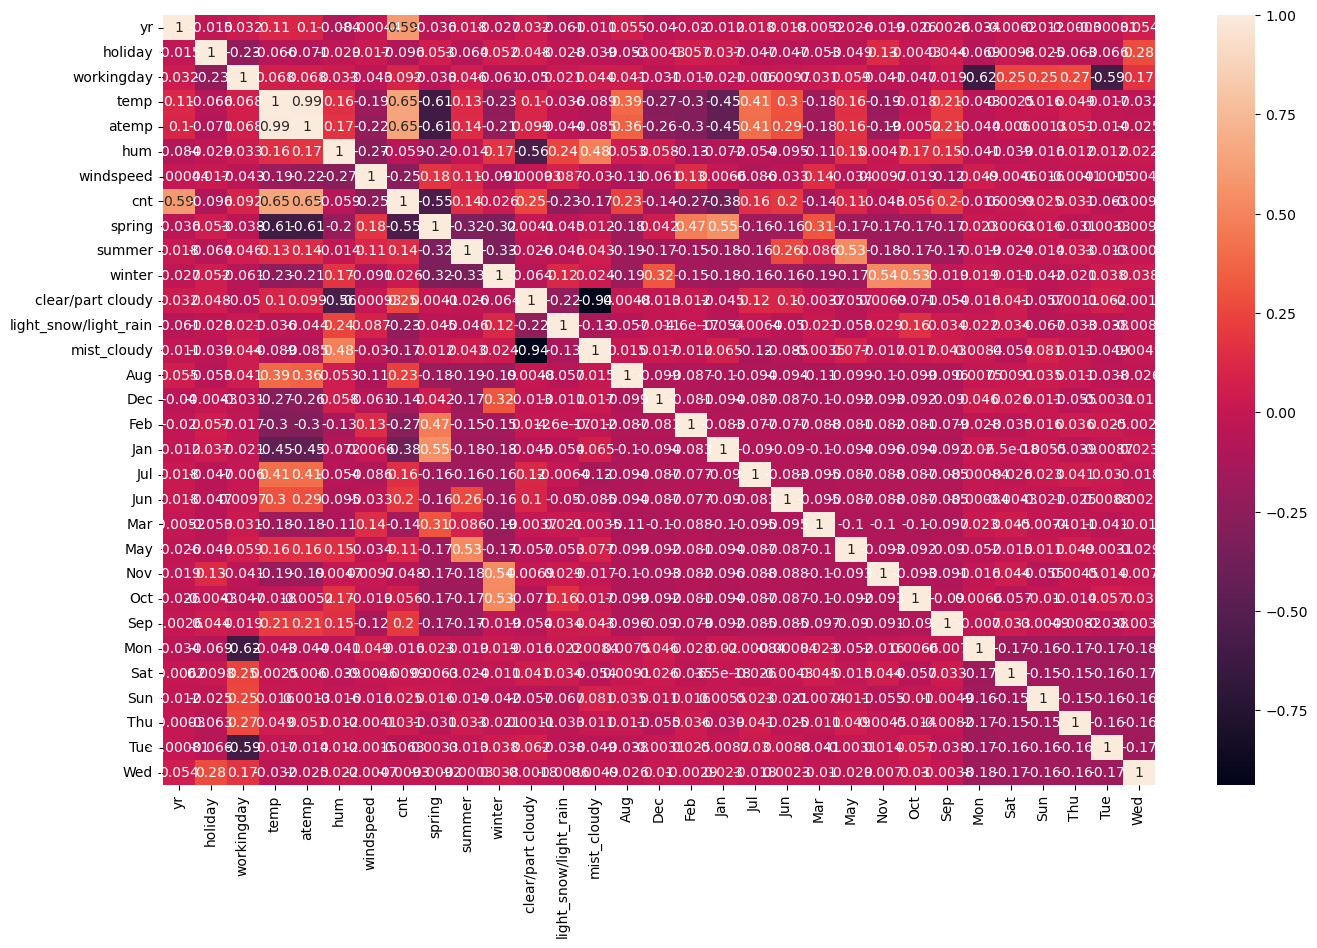

In [27]:
# before starting to train the model we should create a heatmap to understand which variable to pick while model training

plt.figure(figsize = (16,10))
sns.heatmap(df_train.corr(), annot=True)
plt.show()

In [28]:
y_train = df_train.pop("cnt")
X_train = df_train

In [29]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=15)
rfe = rfe.fit(X_train,y_train)

In [30]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('clear/part cloudy', True, 1),
 ('light_snow/light_rain', True, 1),
 ('mist_cloudy', True, 1),
 ('Aug', False, 8),
 ('Dec', False, 4),
 ('Feb', False, 5),
 ('Jan', False, 2),
 ('Jul', True, 1),
 ('Jun', False, 14),
 ('Mar', False, 16),
 ('May', False, 7),
 ('Nov', False, 3),
 ('Oct', False, 13),
 ('Sep', True, 1),
 ('Mon', True, 1),
 ('Sat', False, 15),
 ('Sun', False, 12),
 ('Thu', False, 11),
 ('Tue', False, 9),
 ('Wed', False, 10)]

In [31]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'summer', 'winter', 'clear/part cloudy', 'light_snow/light_rain',
       'mist_cloudy', 'Jul', 'Sep', 'Mon'],
      dtype='object')

In [32]:
X_train_rfe = X_train[col]


lm_rfe = LinearRegression()
lm_rfe.fit(X_train_rfe, y_train)

LinearRegression()

## Step 4: Residual Analysis

In [33]:
y_train_pred = lm_rfe.predict(X_train_rfe)

<AxesSubplot:xlabel='cnt', ylabel='Density'>

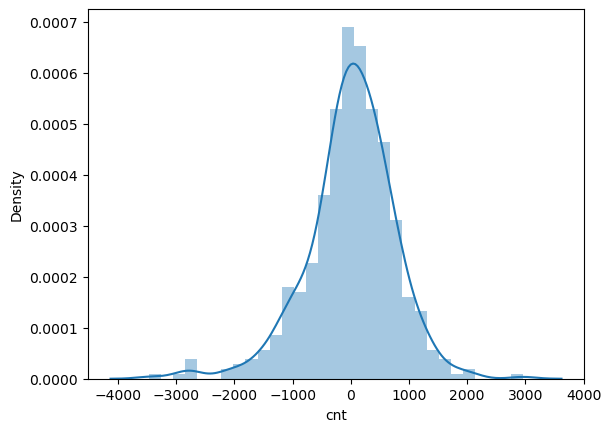

In [34]:
res = y_train - y_train_pred
sns.distplot(res)

## Step 5: Predictions and evaluation on the test set

In [35]:
num_vars = ['temp','atemp','hum','windspeed']

df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test[num_vars].describe()

,temp,atemp,hum,windspeed
count,220.000000,220.000000,220.000000,220.000000
mean,0.558718,0.532847,0.638221,0.313293
std,0.233187,0.217401,0.148694,0.159584
min,0.046591,0.025950,0.261915,-0.042808
25%,0.355429,0.344870,0.529197,0.198843
50%,0.558172,0.544652,0.625590,0.300126
75%,0.755981,0.713308,0.743798,0.402718
max,0.984424,0.980934,1.002146,0.807474


In [36]:
y_test = df_test.pop("cnt")
X_test = df_test

In [37]:
# taking only those columns which considered during model building
X_test_new = X_test[col]

In [38]:
y_pred = lm_rfe.predict(X_test_new)

In [39]:
r2_score(y_test, y_pred)

0.8175945716770194

Text(0, 0.5, 'y_pred')

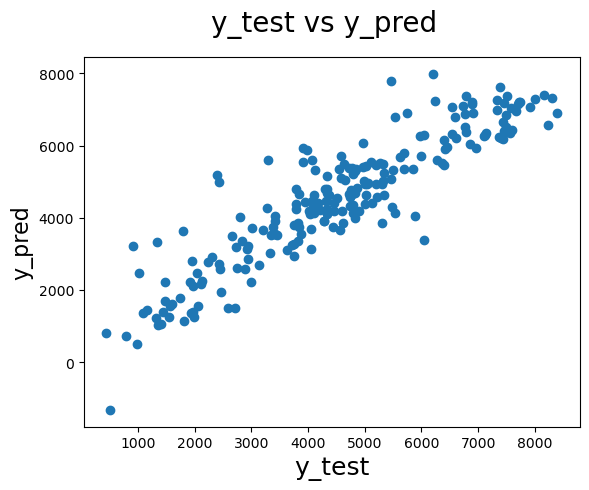

In [40]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)  